# Lista de Exercícios 2: Métodos baseados em Diferenças Temporais

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- ***SUBMISSÕES QUE NÃO SEGUIREM AS INSTRUÇÕES A SEGUIR NÃO SERÃO AVALIADAS.***
- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido antes de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps2.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 09/10/2025. Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Cliff Walking

Cliff Walking é um ambiente representado por um grid de tamanho $4 \times 12$, no qual um agente precisa atravessar o mapa do canto inferior esquerdo até o canto inferior direito, evitando um perigoso penhasco na parte inferior do mapa. O mapa do Cliff Walking pode ser visto no gif abaixo.

![Cliff Walking](https://gymnasium.farama.org/_images/cliff_walking.gif)

O agente sempre inicia na posição $(3, 0)$ e seu objetivo é alcançar a posição $(3, 11)$. As células das três primeiras linhas do grid (linhas $0$, $1$ e $2$) são seguras e o agente pode se mover livremente por elas. Já a linha $3$ contém um penhasco: todas as posições de $(3, 1)$ a $(3, 10)$ representam zonas de risco. Se o agente entrar em uma dessas células, ele cai do penhasco, o que encerra imediatamente o episódio com uma penalidade significativa. A cada passo, o agente recebe uma observação indicando sua posição atual (representada por um valor inteiro) e tem a possibilidade de escolher entre quatro ações possíveis: mover-se para cima, para baixo, para a esquerda ou para a direita. Cada movimento acarreta uma penalidade de $-1$, com exceção das quedas no penhasco, que resultam em uma penalidade severa de $-100$. Um episódio termina quando o agente alcança o objetivo final ou cai do penhasco. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/toy_text/cliff_walking/).

Nesta lista de exercícios, você irá trabalhar com o ambiente Cliff Walking descrito acima. Seu objetivo será implementar e analisar dois algoritmos baseados em diferenças temporais: Sarsa e Q-Learning.

---

## Sarsa

Sua primeira tarefa consiste em implementar um agente baseado no algoritmo Sarsa, que deverá seguir uma política $\varepsilon$-greedy. Para isso, utilize como referência o livro-texto da disciplina e os materiais discutidos em sala.

Você deverá concluir a implementação da classe `SarsaAgent` conforme as instruções abaixo:

1. Implemente o método `__init__` que inicializa um novo agente Sarsa. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$.
2. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
3. Implemente o método `learn`, que atualiza os *Q-values* do agente com base na experiência obtida durante a interação com o ambiente.
4. Implemente o método `train`, que executa o loop de treinamento do algoritmo Sarsa. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar dois elementos: (1) uma tabela contendo os *Q-values* calculados durante o treinamento; e (2) uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [1]:
import sys
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
class SarsaAgent:
    # construtor
    def __init__(self, observation_space, action_space, alpha, gamma, epsilon):
        
        self.obs_space = observation_space # número de estados possíveis
        self.action_space = action_space # numero ações que o agente pode fazer ou perceber
        
        self.alpha = alpha # taxa de aprendizado [0<=alpha<=1] - velocidade de aprendizado
        

        # o gama diferencia as recompensas temporalmente, podendo valorizar recompensas obtidas recentemente
        self.gamma = gamma # fator de desconto [0<=gama<=1] - é a importância das recompensas futuras
        
        
        
        self.epsilon = epsilon  # taxa de exploração [e-greedy]
        # Inicializa a Q-table com zeros. 
        self.q_table = np.zeros((self.obs_space.n, self.action_space.n))

    # Política epsilon-greedy
    def choose_action(self, state):
        
        
        # np.random.random() gera numero decimal entre 0 e 1
        # se epsilon for 0.1, haverá 90% de chance de usar a abordagem exploit
        
        # Verificação com probabilidade (1 - epsilon)
        if np.random.random() > self.epsilon: 
            # escolhe a melhor ação (exploit)
            return np.argmax(self.q_table[state])
            
        # Com probabilidade epsilon
        else:
            # Escolhe uma ação aleatória (explore)
            return self.action_space.sample()

    # atualiza a opião do agente sobre o quão bom foi ter tomado certa action naquele state
    def learn(self, state, action, reward, next_state, next_action):
        # Fórmula de atualização do Sarsa

        # valor que o agente esperava receber com a ação (estava dentro da tabela)
        predict = self.q_table[state, action] 

        # O target representa o valor verdadeiro da recompensa esperada
        # com base na experincia feita
        
        # recompensa imediata recebida com ação + fator de desconto * valor esperado da prox ação 
        target = reward + self.gamma * self.q_table[next_state, next_action] # recalculado
        
        # Usa o valor ANTIGO (predict) e o  
        # (target) para calcular o NOVO valor e sobrescrever o local na Q-Table.
        self.q_table[state, action] += self.alpha * (target - predict) # atualização 

    # treina o agente dentro do ambiente env por rodadas completas(episodes)
    def train(self, env, episodes):
        rewards_per_episode = [] # armazenará a soma das recompensa em cada episodio
        
        # loop que faz o agente passar pelos episódios 
        
        for episode in range(episodes): # episode é o numero de vzes qeu o agente opera
            state, info = env.reset() # reinicia o ambiente - isso pode conter info adicionais
            action = self.choose_action(state) # decisão qual ação fazer 
            
            terminated = False # indica se o episodio terminou por atingir o objetivo
            truncated = False # indica se o episodio foi interrompido 
            total_rewards = 0 # é o retorno do episodio

            
            while not terminated and not truncated:
                # o agente executa a ação atual e o ambiente retorna:
                next_state, reward, terminated, truncated, info = env.step(action)
                # com o novo estado o agente escolha a próxima ação
                next_action = self.choose_action(next_state)
                
                # Atualiza o Q-value com base na transição
                self.learn(state, action, reward, next_state, next_action)
                
                state = next_state
                action = next_action
                total_rewards += reward
            
            rewards_per_episode.append(total_rewards)
        
        # retorna a tabela e o retorno por episodio
        return self.q_table, rewards_per_episode

4. Agora, treine um novo agente Sarsa no ambiente Cliff Walking por 1000 episódios utilizando os seguintes parâmetros: taxa de aprendizado $\alpha = 0.1$, fator de desconto $\gamma = 0.9$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene a saída do método `train` nas variáveis `sarsa_q_table` e `sarsa_returns`.

In [4]:
env = gym.make("CliffWalking-v0")

# Parâmetros
alpha = 0.1
gamma = 0.9
epsilon = 0.1
episodes = 1000

# Criação e treinamento do agente
sarsa_agent = SarsaAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon
)
sarsa_q_table, sarsa_returns = sarsa_agent.train(env, episodes)

env.close()

In [5]:
# Não altere ou remova esta célula

Nas células a seguir, analise com atenção a política gulosa obtida a partir do treinamento com o algoritmo Sarsa. Na última parte desta lista, você deverá responder algumas perguntas relacionadas a essa política.

In [6]:
def print_greedy_policy(q_table):

    action_map = ['↑', '→', '↓', '←']
    q_table = np.array(q_table)

    if q_table.shape != (48, 4):
        raise ValueError("Q-table must have shape (48, 4)")

    for row in range(4):
        line = []
        for col in range(12):
            state = row * 12 + col
            if row == 3:
                char = (
                    action_map[np.argmax(q_table[state])] if col == 0 else
                    '◎' if col == 11 else
                    '▢'
                )
            else:
                char = action_map[np.argmax(q_table[state])]
            line.append(char)
        print(' '.join(line))

In [7]:
print_greedy_policy(sarsa_q_table)

→ → → → → → → → → → ↓ ↓
→ → → → → → → → → → → ↓
↑ ↑ → ← ↑ ↑ ← ↑ ↑ ↑ → ↓
↑ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ◎


---

## Q-Learning

Nesta atividade, você deverá implementar um agente baseado no algoritmo Q-learning, que também utiliza uma política $\varepsilon$-greedy para explorar o ambiente durante o treinamento. Novamente, utilize o livro-texto da disciplina e os materiais discutidos em sala de aula como referência.

Você deverá concluir a implementação da classe QLearningAgent, conforme as instruções a seguir:

5. Implemente o método `__init__` que inicializa um novo agente Q-Learning. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$.
6. Implemente a função `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
7. Implemente a função `learn`, que atualiza os *Q-values* do agente com base na experiência obtida durante a interação com o ambiente.
8. Implemente o método `train`, que executa o loop de treinamento do algoritmo Q-Learning. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar dois elementos: (1) uma tabela contendo os *Q-values* calculados durante o treinamento; e (2) uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [8]:
class QLearningAgent:
    def __init__(self, observation_space, action_space, alpha, gamma, epsilon):
        self.obs_space = observation_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((self.obs_space.n, self.action_space.n))

    def choose_action(self, state):
        # Política ε-greedy (idêntica ao Sarsa)
        if np.random.random() > self.epsilon:
            return np.argmax(self.q_table[state])
        else:
            return self.action_space.sample()

    def learn(self, state, action, reward, next_state):
        # Fórmula de atualização do Q-Learning
        predict = self.q_table[state, action]
        # A principal diferença está aqui: usa o máximo Q-value do próximo estado
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (target - predict)

    def train(self, env, episodes):
        rewards_per_episode = []
        for episode in range(episodes):
            state, info = env.reset()
            
            terminated = False
            truncated = False
            total_rewards = 0
            
            while not terminated and not truncated:
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                
                # Atualiza o Q-value (note que não precisa da "próxima ação")
                self.learn(state, action, reward, next_state)
                
                state = next_state
                total_rewards += reward
                
            rewards_per_episode.append(total_rewards)
            
        return self.q_table, rewards_per_episode

9. Treine este novo agente por 1000 episódios no ambiente Cliff Walking. Utilize os mesmos parâmetros do exercício 4. Armazene a saída do método `train` nas variáveis `ql_q_table` e `ql_returns`.

In [10]:
env = gym.make("CliffWalking-v0")

# Parâmetros
alpha = 0.1
gamma = 0.9
epsilon = 0.1
episodes = 1000

# Criação e treinamento do agente
q_learning_agent = QLearningAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon
)
ql_q_table, ql_returns = q_learning_agent.train(env, episodes)

env.close()

In [11]:
# Não altere ou remova esta célula

Analise com atenção a política gulosa obtida a partir do treinamento com o algoritmo Q-Learning. Na próxima parte desta lista, você deverá responder algumas perguntas relacionadas a essa política.


In [12]:
print_greedy_policy(ql_q_table)

↓ → ← ← ↑ ↑ → → → → → ↓
→ ↓ → ↓ ↓ ↓ ↓ → → ↓ → ↓
→ → → → → → → → → → → ↓
↑ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ◎


---

## Análise

10. As políticas obtidas pelos agentes Sarsa e Q-learning apresentam diferenças significativas? Explique por que essas diferenças ocorrem - ou por que não ocorrem.

**As políticas são diferentes**:
O Sarsa aprendeu de forma segura, contudo o caminho mais longo acima do penhasco
O Q-Learning aprendeu o caminho ótimo, próximo ao penhasco e com menor número de passos (maior recompensa)

**Explicação**:
O SARSA atualiza sua tabela Q com base nas ações que o agente realmente executa, incluindo aquelas escolhidas exploratoriamente (on-policy). Já o Q-Learning atualiza a Q-table considerando a ação tomada no estado atual, mas projeta o máximo valor esperado da próxima ação segundo a tabela, sem levar em conta qual ação foi realmente escolhida. Em outras palavras, o Q-Learning aprende de forma otimista, assumindo que o agente sempre seguirá a melhor ação possível (off-policy ou política ótima (pode ser diferente da política que está sendo executando de fato)).

Isso faz com que o Q-learning ignore risco de queda no penhasco, enquanto o Sarsa ajam com cautela, escolhendo um caminho mais longo.


11. Utilize a biblioteca *matplotlib* para construir um gráfico comparativo dos retornos episódicos obtidos pelos algoritmos Sarsa e Q-Learning. Utilize as variáveis `sarsa_returns` e `ql_returns` obtidas nos exercícios anteriores. No eixo X, represente os episódios; no eixo Y, o retorno acumulado por episódio. Lembre-se de incluir título e legendas apropriadas para facilitar a interpretação dos dados.

**Importante:** O gráfico gerado deve se assemelhar ao exemplo abaixo. Embora os resultados dificilmente sejam idênticos, é fundamental que as tendências de cada algoritmo estejam bem evidentes. Caso os dados estejam muito ruidosos e dificultem a visualização das tendências, experimente aplicar uma média móvel ou outro método outro método de suavização de curvas. Se utilizar algum tipo de suavização, indique claramente no gráfico qual o método aplicado.

![Sarsa vs Q-Learning](sarsa-vs-qlearn.png)

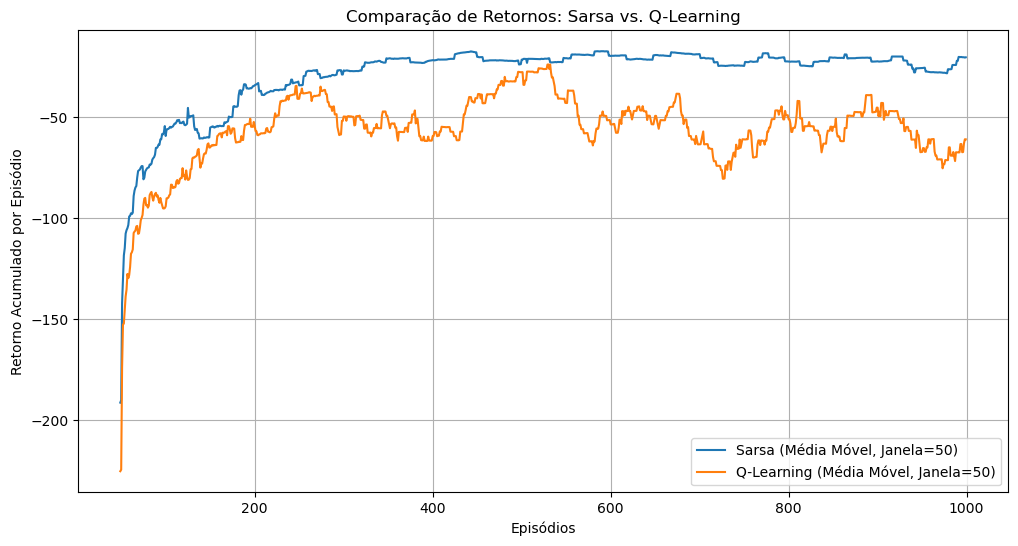

In [13]:
def moving_average(data, window_size):
    """Calcula a média móvel de uma série de dados."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Parâmetros para a suavização
window_size = 50

# Aplica a média móvel
sarsa_smoothed = moving_average(sarsa_returns, window_size)
ql_smoothed = moving_average(ql_returns, window_size)
# Ajusta o eixo x para corresponder aos dados suavizados
episodes_smoothed = np.arange(window_size - 1, len(sarsa_returns))

plt.figure(figsize=(12, 6))
plt.plot(episodes_smoothed, sarsa_smoothed, label=f'Sarsa (Média Móvel, Janela={window_size})')
plt.plot(episodes_smoothed, ql_smoothed, label=f'Q-Learning (Média Móvel, Janela={window_size})')
plt.title('Comparação de Retornos: Sarsa vs. Q-Learning')
plt.xlabel('Episódios')
plt.ylabel('Retorno Acumulado por Episódio')
plt.legend()
plt.grid(True)
plt.show()

12. Realize um novo treinamento do agente Sarsa, desta vez utilizando $\varepsilon = 0$, ou seja, adotando uma política puramente gulosa. Preserve todos os outros parâmetros utilizados anteriormente e armazene a saída do método `train` nas variáveis `sarsa_q_table` e `sarsa_returns`. Ao final do treinamento, observe a política aprendida.

In [14]:
env = gym.make("CliffWalking-v0")

# Parâmetros com epsilon = 0
alpha = 0.1
gamma = 0.9
epsilon_zero = 0.0  # Política puramente gulosa
episodes = 1000

# Criação e treinamento do agente Sarsa com epsilon = 0
sarsa_greedy_agent = SarsaAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon_zero
)
sarsa_q_table, sarsa_returns = sarsa_greedy_agent.train(env, episodes)

env.close()

print("Política aprendida pelo Sarsa com ε = 0:")
print_greedy_policy(sarsa_q_table)

Política aprendida pelo Sarsa com ε = 0:
→ ← → → ↑ ← → → → → ← ↓
↓ ↑ ↑ → → ↓ ↑ → → → ↓ ↓
→ → → → → → → → → → → ↓
↑ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ▢ ◎


In [15]:
# Não altere ou remova esta célula

13. Quando o parâmetro de exploração $\varepsilon$ é fixado em zero para ambos algoritmos, o Sarsa torna-se equivalente ao Q-learning? Ambos selecionarão as mesmas ações e realizarão as mesmas atualizações de pesos?

Não exatamente, pois o SARSA ainda aprende com base nas ações que ele realmente executa, seguindo sua própria política, mesmo que essa política seja a ótima, como acontece quando epsolon=0. Nesse caso, o SARSA não realiza mais exploração, mas continua sendo on-policy,mas na prática seu comportamento se aproxima do Q-Learning, porque a próxima ação escolhida é sempre a de maior Q-value.